In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [30]:
##########################preprocess data##################################
data = pd.read_excel('./OppScrData.xlsx', index_col=None)
data=data[data.columns[0:52]]
data.head()
clinical_col=data.columns[0:14]
outcome_col=data.columns[15:40]
#CT data
CT_col=data.columns[41:52]
CT_data=data[CT_col]
CT_data=CT_data.fillna(CT_data.mean())
CT_data['Liver HU    (Median)']=pd.to_numeric(CT_data['Liver HU    (Median)'],errors='coerce')
CT_data=CT_data.fillna(CT_data.mean())
CT_data=CT_data.astype(float)
##clinical data
CL_data=data[clinical_col]
CL_data=CL_data.drop(columns=['Record ID', 'Visit ID', 'PT ID','BMI >30', 'Met Sx'])
CL_data['BMI']=CL_data['BMI'].fillna(CL_data['BMI'].mean())
(CL_data['Tobacco']=='Yes').sum()/len(CL_data)
CL_data['Tobacco']=CL_data['Tobacco'].fillna('No')
CL_data['Alcohol abuse']=CL_data['Alcohol abuse'].fillna(0)
CL_data['Alcohol abuse']=CL_data['Alcohol abuse'].apply(lambda x: 1 if x!=0 else 0)
for i in ['Sex','Tobacco']:
    CL_data[i] = pd.factorize(CL_data[i])[0] + 1
CL_data['FRS 10-year risk (%)']=CL_data['FRS 10-year risk (%)'].apply(lambda x: 0.005 if x=='<1%' else x)
CL_data['FRS 10-year risk (%)']=CL_data['FRS 10-year risk (%)'].apply(lambda x: 0.3 if x=='>30%' else x)
fm=np.mean(CL_data['FRS 10-year risk (%)'][CL_data['FRS 10-year risk (%)']!='X'])
CL_data['FRS 10-year risk (%)']=CL_data['FRS 10-year risk (%)'].apply(lambda x: fm if x=='X' else x)
for i in ['FRS 10-year risk (%)','FRAX 10y Fx Prob (Orange-w/ DXA)','FRAX 10y Hip Fx Prob (Orange-w/ DXA)']:
    CL_data[i]=pd.to_numeric(CL_data[i],errors='coerce')
    CL_data[i]=CL_data[i].fillna(CL_data[i].mean())
CL_CT_data=pd.concat([CL_data,CT_data],axis=1)

In [31]:
##data normalization########################
X = CL_CT_data.values
training_X, testing_X = train_test_split(X, test_size = 0.2,random_state=2)
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_X = sc.fit_transform(training_X)
testing_X = sc.transform(testing_X)

In [32]:
##extract labelled data######################
death=data['DEATH [d from CT]'][~np.isnan(data['DEATH [d from CT]'])]
y = death.values
CL_CT_data=CL_CT_data[~np.isnan(data['DEATH [d from CT]'])]
X=CL_CT_data.values
X=sc.transform(X)

In [33]:
##traditional weighted KNN ###########################
nd=2
def weighted_KNN(train_X,train_y,test_x,K):
    dist=np.zeros(len(train_y))
    for i in range(len(train_y)):
        dist[i]=np.linalg.norm(test_x-train_X[i],nd)
    dist_ind=dist.argsort()[0:K]
    dist=dist[dist_ind]
    weight=np.exp(-dist)/np.sum(np.exp(-dist))
    y_weight=np.float64(train_y[dist_ind]*weight)
    y_mean=np.sum(y_weight)
    return(y_mean)

In [34]:
##prediction with only CT data ####################
CT_data=CT_data[~np.isnan(data['DEATH [d from CT]'])]
CT_X=CT_data.values
sc1 = MinMaxScaler()
CT_X=sc1.fit_transform(CT_X)
CT_X_train, CT_X_test ,y_train,y_test= train_test_split(CT_X, y,test_size = 0.2,random_state=2)
y_pred=[]
acc=[]
kk=15
for i in range(len(y_test)):
    y_pred.append(weighted_KNN(CT_X_train,y_train,CT_X_test[i],kk))
    acc.append(y_pred[i]-y_test[i])
np.absolute(acc).sum()/len(y_test)

1020.907938852341

Text(0, 0.5, 'Mean Absolute Error')

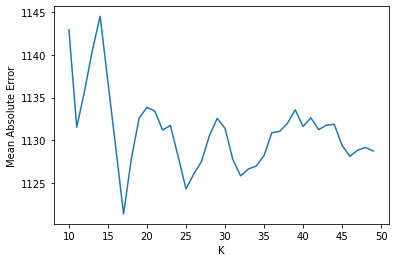

In [35]:
##10 fold validation on K
## 10-fold validation
kacc=[]
num=len(y_train)//10
folds=[]
y_folds=[]
for i in range(10):
    foldi=CT_X_train[(num*i):(num*i+num),:]
    y_foldi=y_train[(num*i):(num*i+num)]
    folds.append(foldi)
    y_folds.append(y_foldi) 
for kk in range(10,50):
    acc=[]
    for i in range(10):
        folds1=folds.copy()
        y_folds1=y_folds.copy()
        del folds1[i]
        del y_folds1[i]
        CT_train_x=np.vstack(folds1)
        CT_val_x=folds[i]
        val_y=y_folds[i]
        train_y=np.hstack(y_folds1)
        sc1 = MinMaxScaler()
        CT_train_X = sc1.fit_transform(CT_train_x)
        CT_val_X = sc1.transform(CT_val_x) 
        for j in range(len(val_y)):
            pred=weighted_KNN(CT_train_X,train_y,CT_val_X[j],kk)
            acc.append(np.absolute(val_y[j]-pred))
    kacc.append(sum(acc)/len(val_y)/10)
plt.plot(range(10,50),kacc)
plt.xlabel('K')
plt.ylabel('Mean Absolute Error')

In [36]:
##prediction with clinical data without encoding####################
X_train, X_test ,y_train,y_test= train_test_split(X, y,test_size = 0.2,random_state=2)
y_pred=[]
y_lab=[]
acc=[]
kk=15
for i in range(len(y_test)):
    y_pred_all=weighted_KNN(X_train,y_train,X_test[i],kk)
    y_pred.append(np.mean(y_pred_all))
    y_lab.append(y_pred[i])
    acc.append(y_lab[i]-y_test[i])
np.absolute(acc).sum()/len(y_test)

394.3238254441745

In [37]:
##sparse auto encoder#########################
#initialize latent dimension
latent_dim = 10 
class Autoencoder(Model):
  def leaky_relu(x): 
      return tf.keras.activations.relu(x,alpha=0.1, max_value=None, threshold=0.0)
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Dense(16, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(latent_dim, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(np.size(X,1), activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)
#model compile
autoencoder.compile(optimizer='adam', loss=losses.MeanAbsoluteError())

In [38]:
#fit the model with all the data
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
autoencoder.fit(training_X, training_X,
                epochs=300,
                shuffle=True,
                batch_size=16, 
                callbacks=[callback],
                validation_data=(testing_X, testing_X))

Epoch 1/300
462/462 [==============================] - 1s 2ms/step - loss: 0.1750 - val_loss: 0.1063
Epoch 2/300
462/462 [==============================] - 1s 1ms/step - loss: 0.0971 - val_loss: 0.0904
Epoch 3/300
462/462 [==============================] - 1s 1ms/step - loss: 0.0778 - val_loss: 0.0682
Epoch 4/300
462/462 [==============================] - 1s 1ms/step - loss: 0.0640 - val_loss: 0.0603
Epoch 5/300
462/462 [==============================] - 1s 1ms/step - loss: 0.0554 - val_loss: 0.0545
Epoch 6/300
462/462 [==============================] - 1s 1ms/step - loss: 0.0502 - val_loss: 0.0487
Epoch 7/300
462/462 [==============================] - 1s 1ms/step - loss: 0.0467 - val_loss: 0.0464
Epoch 8/300
462/462 [==============================] - 1s 1ms/step - loss: 0.0448 - val_loss: 0.0453
Epoch 9/300
462/462 [==============================] - 1s 1ms/step - loss: 0.0440 - val_loss: 0.0444
Epoch 10/300
462/462 [==============================] - 1s 1ms/step - loss: 0.0436 - val_lo

In [39]:
##encode labbeled data
sparse_encodedX=autoencoder.encoder(X).numpy()
#remove zero columns in the sparse encoder
encodedX=sparse_encodedX[:,np.any(sparse_encodedX != 0, axis=0)]
#split train test
encoded_X_train, encoded_X_test ,y_train,y_test= train_test_split(encodedX, y,test_size = 0.2,random_state=2)

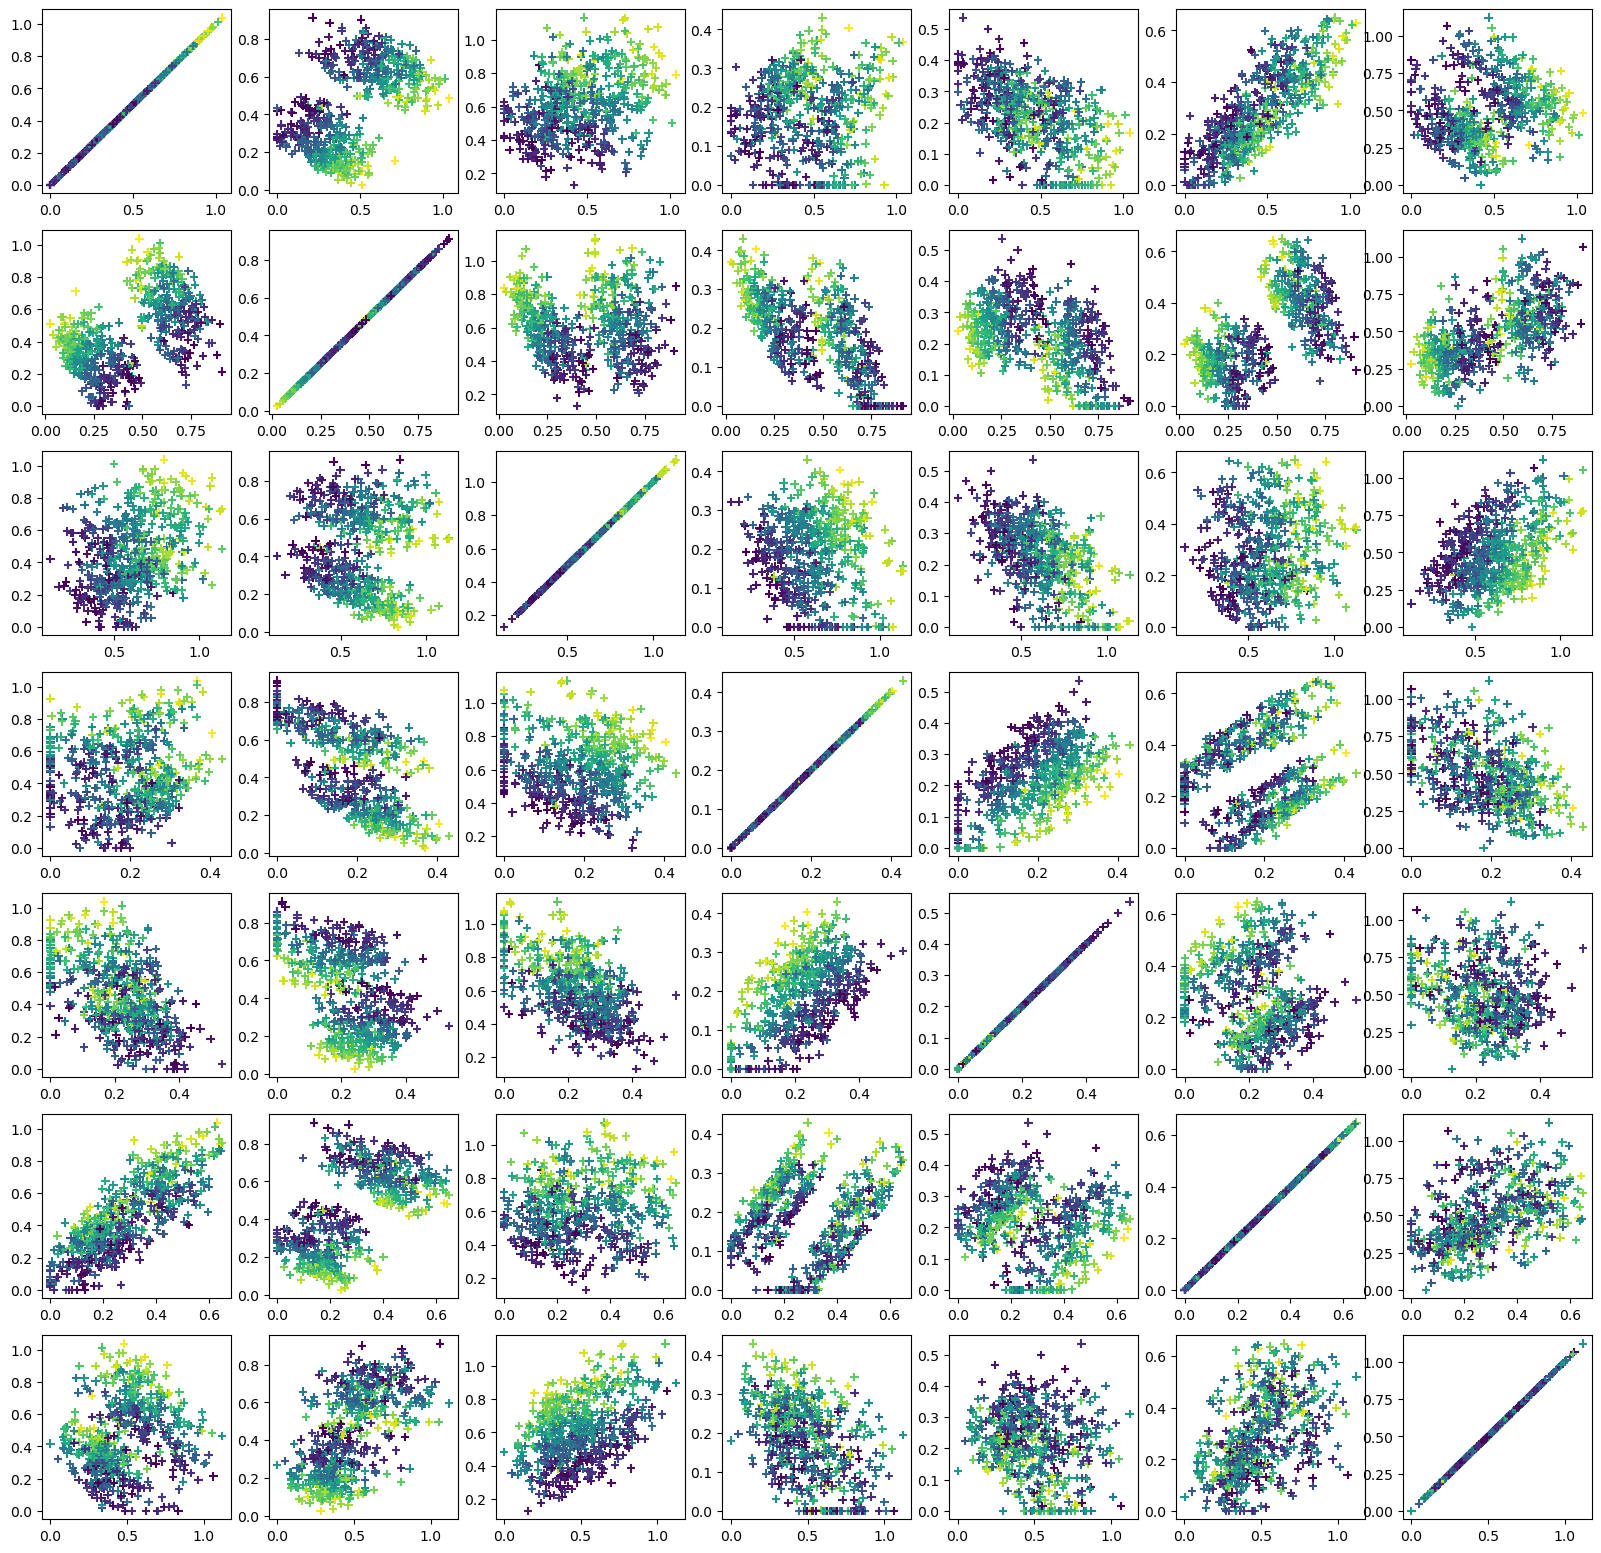

In [40]:
##plot the relation of encoded features
new_dim=np.shape(encodedX)[1]
figure, axis = plt.subplots(new_dim, new_dim)
fig =plt.gcf()
fig.set_size_inches(20, 20)
fig.set_dpi(100)
for i in range(new_dim):
    for j in range(new_dim):
        axis[i,j].scatter(encodedX[:,i],encodedX[:,j],c=y, cmap='viridis',marker='+')
        #axis[i,j].set_title("Sine Function")
plt.show()
fig.savefig('new2newfeature.png')

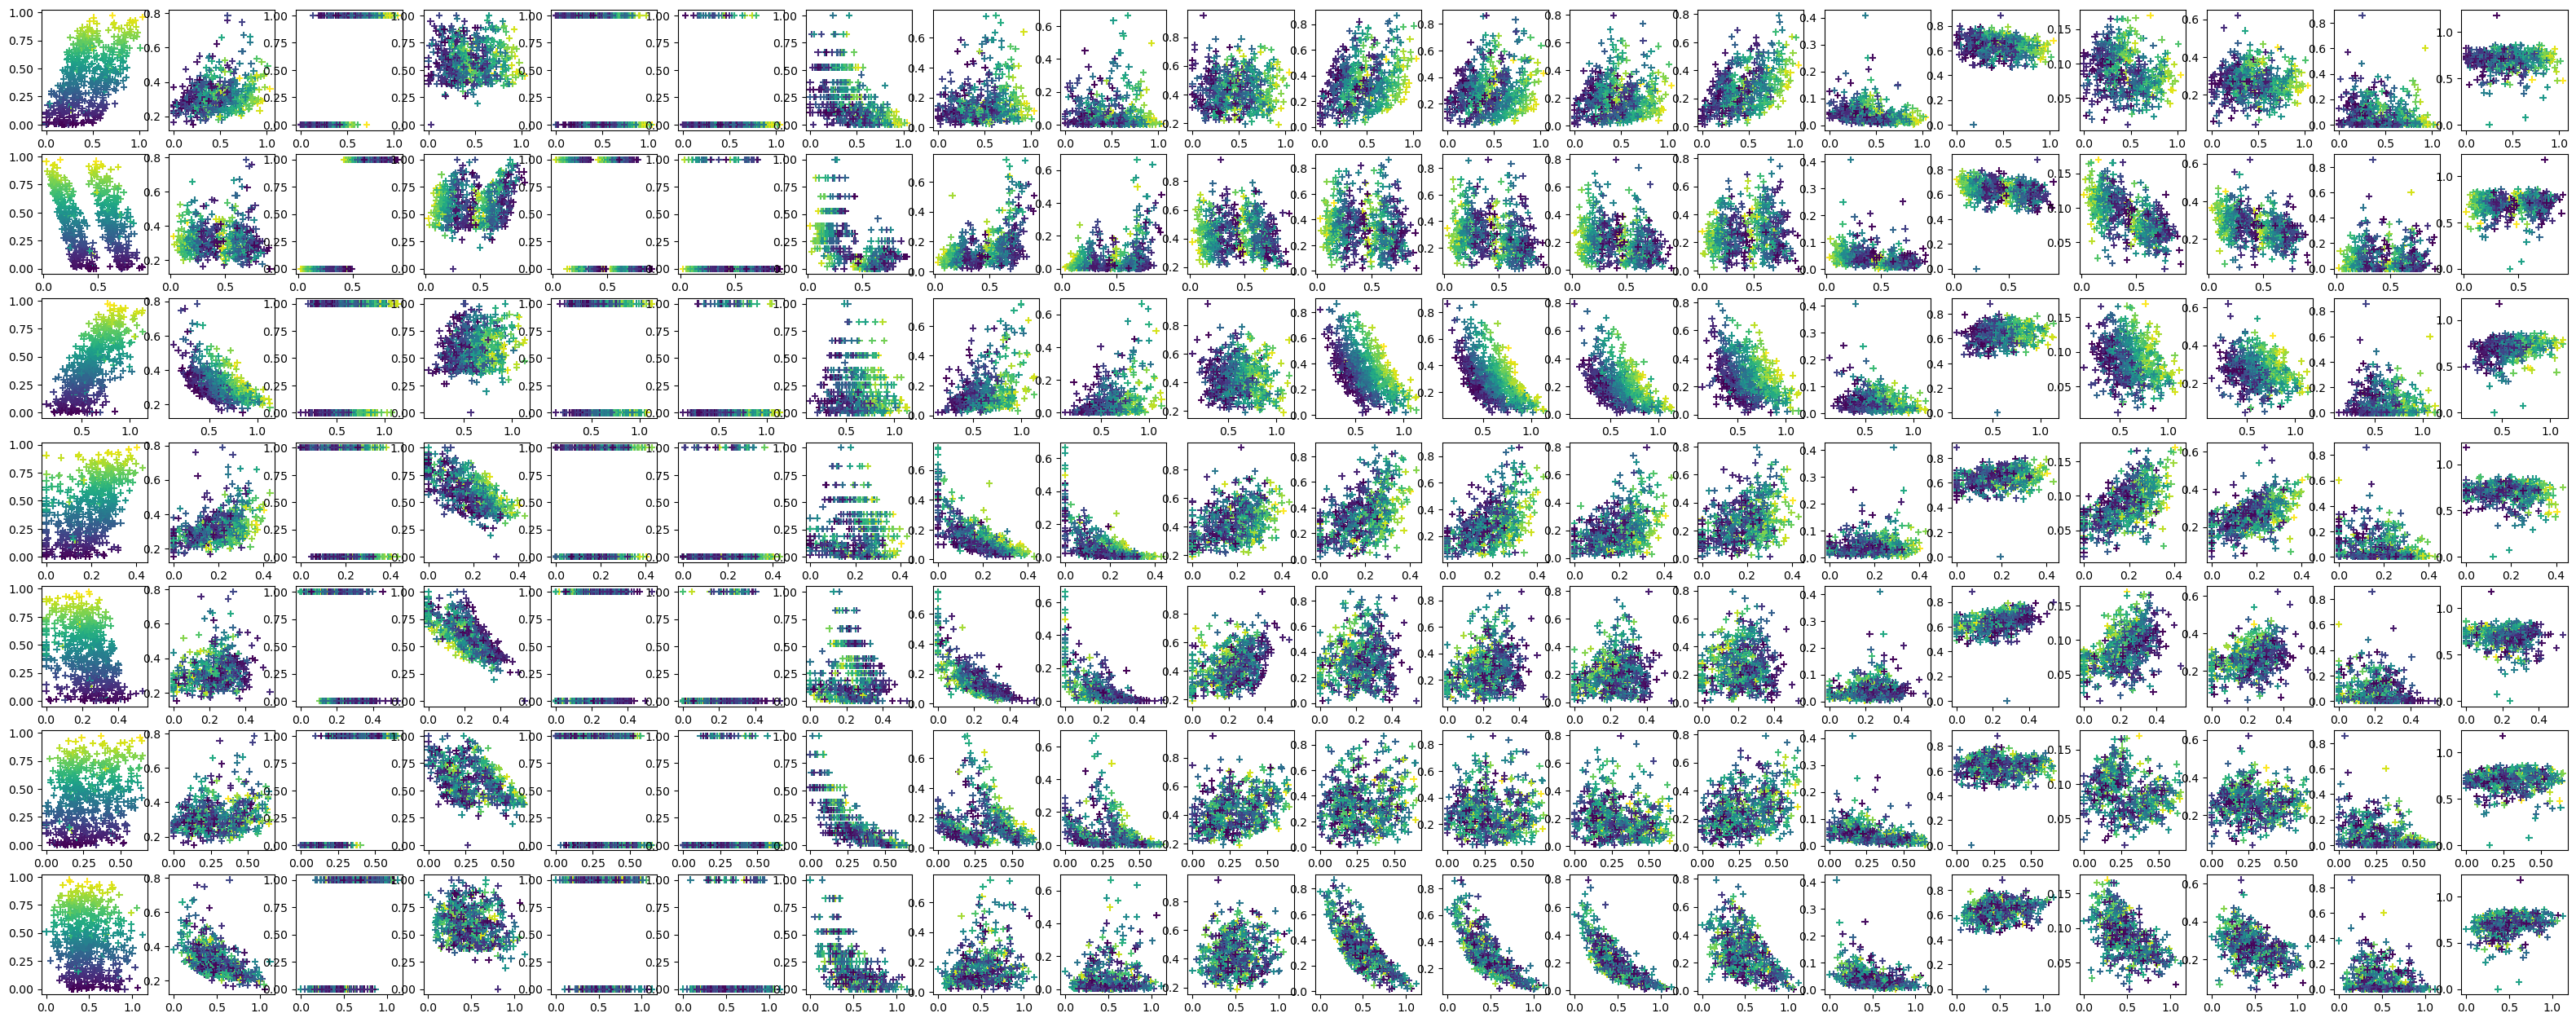

In [41]:
##plot the relation of encoded features and orginal features
figure, axis = plt.subplots(new_dim, np.shape(X)[1])
fig =plt.gcf()
fig.set_size_inches(40, 16)
fig.set_dpi(100)
for i in range(new_dim):
    for j in range(np.shape(X)[1]):
        axis[i,j].scatter(encodedX[:,i],X[:,j],c=y, cmap='viridis',marker='+')
plt.show()
fig.savefig('new2oldfeature.png')

In [42]:
##prediction on encoded data
encoded_y_pred=[]
encoded_acc=[]
kk=15
for i in range(len(y_test)):
    encoded_y_pred.append(weighted_KNN(encoded_X_train,y_train,encoded_X_test[i],kk))
    encoded_acc.append(encoded_y_pred[i]-y_test[i])
np.absolute(encoded_acc).sum()/len(y_test)

248.23826511044294

In [43]:
##Constrained weighted KNN######################
#calculate the distance of dat points
def KNN_dist(train_X,test_x):
    dist=np.zeros(np.shape(train_X)[0])
    for i in range(np.shape(train_X)[0]):
        dist[i]=np.linalg.norm(test_x-train_X[i],nd)
    return(dist)

(array([ 660., 3859., 6805., 7657., 9081., 9302., 7423., 2772.,  662.,
          69.]),
 array([0.02353053, 0.15787937, 0.29222821, 0.42657705, 0.56092589,
        0.69527473, 0.82962357, 0.96397242, 1.09832126, 1.2326701 ,
        1.36701894]),
 <a list of 10 Patch objects>)

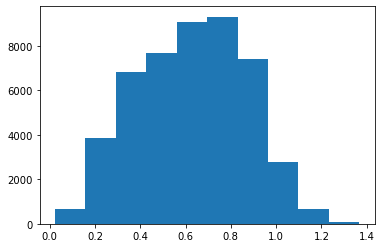

In [44]:
dist=[]
for i in range(len(y_test)):
    dist.append(KNN_dist(encoded_X_train,encoded_X_test[i]))
dist=[item for sublist in dist for item in sublist]
plt.hist(dist)

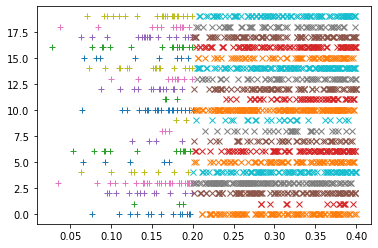

In [45]:
plt.figure()
r=0.4
p=0.2
for i in range(20):
    dist=KNN_dist(encoded_X_train,encoded_X_test[i])
    dist=dist[dist<r]
    plt.plot(dist[dist<p],[i]*len(dist[dist<p]),'+')
    plt.plot(dist[dist>=p],[i]*len(dist[dist>=p]),'x')
plt.show()

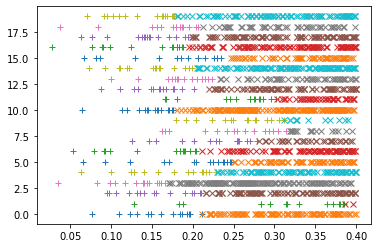

In [46]:
k=15
r=0.4
for i in range(20):
    dist=KNN_dist(encoded_X_train,encoded_X_test[i])
    dist=dist[dist<r]
    dist=np.sort(dist)
    plt.plot(dist[0:k],[i]*len(dist[0:k]),'+')
    plt.plot(dist[k:],[i]*len(dist[k:]),'x')
plt.show()

In [47]:
def constrained_KNN(train_X,train_y,test_x,l,k):
    dist=np.zeros(len(train_y))
    for i in range(len(train_y)):
        dist[i]=np.linalg.norm(test_x-train_X[i],nd)
    dist_ind=dist.argsort()[0:k]
    dist=dist[dist_ind]
    y_lab=train_y[dist_ind]
    y_lab=y_lab[dist<l]
    dist=dist[dist<l]
    weight=np.exp(-dist)/np.sum(np.exp(-dist))
    y_weight=np.float64(y_lab*weight)
    y_mean=np.sum(y_weight)
    return(y_mean)

In [51]:
constrained_encoded_y_pred=[]
constrained_encoded_y_lab=[]
constrained_encoded_acc=[]
for i in range(len(y_test)):
    constrained_encoded_y_pred=constrained_KNN(encoded_X_train,y_train,encoded_X_test[i],0.25,30)
    constrained_encoded_acc.append(constrained_encoded_y_pred-y_test[i])
np.absolute(constrained_encoded_acc).sum()/len(y_test)

285.4215158634903

{'whiskers': [<matplotlib.lines.Line2D at 0x1b361e954c0>,
 'caps': [<matplotlib.lines.Line2D at 0x1b361bbdaf0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b361e957f0>,
 'medians': [<matplotlib.lines.Line2D at 0x1b361bbd220>,
 'fliers': [<matplotlib.lines.Line2D at 0x1b361bbda30>,
 'means': []}

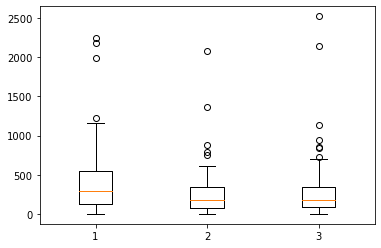

In [52]:
plt.boxplot([np.absolute(acc),np.absolute(encoded_acc),np.absolute(constrained_encoded_acc)])